In [54]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

# Random Forest (Ensemble of Decision Trees)

Random forests are an example of an ensemble learner built on **decision trees**.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of yes/no questions:

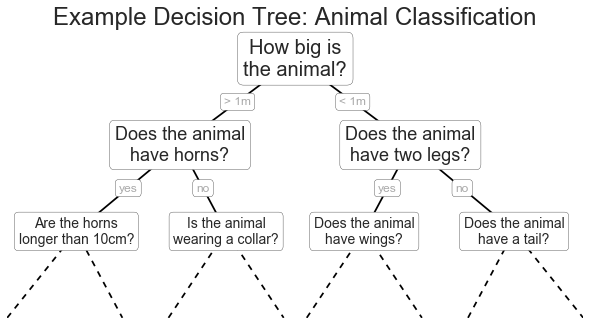

In [55]:
import fig_code
fig_code.plot_example_decision_tree()

The binary splitting makes this extremely efficient (log).

The trick is to *ask the right questions*. This is where the algorithmic process comes in: in training a decision tree classifier, the algorithm looks at the features and decides which questions (or "splits") contain the most information.

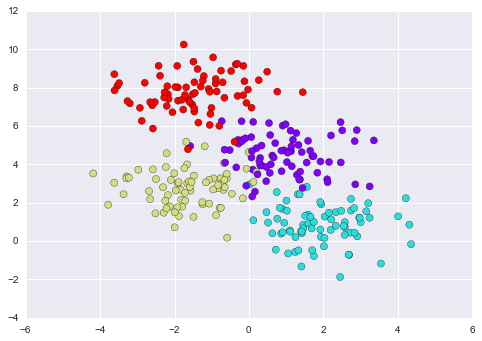

In [56]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

In [57]:
from fig_code import visualize_tree, plot_tree_interactive

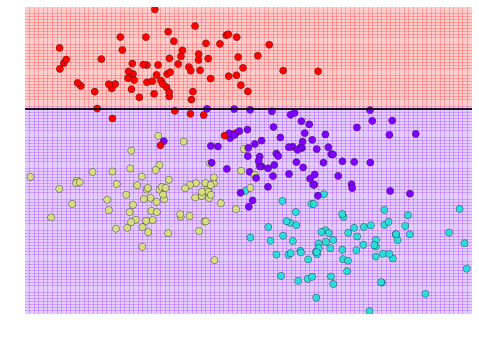

In [58]:
plot_tree_interactive(X, y);

At each increase in depth, every node is split in two **except** those nodes which contain only a single class.
The result is a very fast **non-parametric** classification, and can be extremely useful in practice.

**Question: Do you see any problems with this?**

### Decision Trees and over-fitting

One issue with decision trees is that it is very easy to create trees which **over-fit** the data. That is, they are flexible enough that they can memorisze the structure of the noise in the data rather than the signal! For example, take a look at two trees built on two subsets of this dataset:

## Ensembles of Estimators: Random Forests

One way to address over-fitting is to use an **Ensemble Method**: averages the results of many individual estimators which over-fit the data. Somewhat surprisingly, the resulting estimates are much more robust and accurate than the individual estimates which make them up!

One of the most common ensemble methods is the **Random Forest**, in which the ensemble is made up of many decision trees which are in some way perturbed.

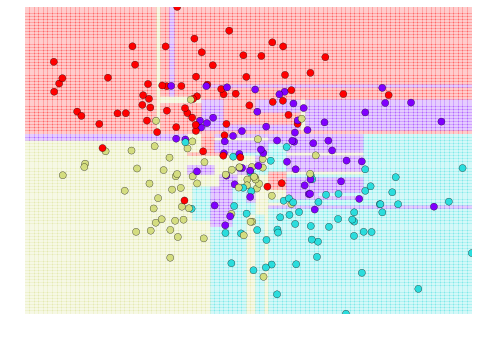

In [59]:
from sklearn.tree import DecisionTreeClassifier
def fit_randomized_tree(random_state=0):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=2.0)
    clf = DecisionTreeClassifier(max_depth=15)
    
    rng = np.random.RandomState(random_state)
    i = np.arange(len(y))
    rng.shuffle(i)
    visualize_tree(clf, X[i[:250]], y[i[:250]], boundaries=False,
                   xlim=(X[:, 0].min(), X[:, 0].max()),
                   ylim=(X[:, 1].min(), X[:, 1].max()))
    
from IPython.html.widgets import interact
interact(fit_randomized_tree, random_state=[0, 100]);

and make an average

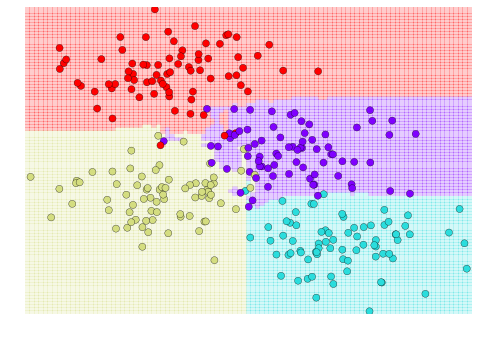

In [60]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_tree(clf, X, y, boundaries=False);

<img src="figures/regression.png" width="60%">

## Example: Photometric Redshift
### Random forest regression

Classification is often a regression with a function applied that returns a number between 0,1. By setting a threshold, you can get closer to the label 0 $(f< threshold)$ or label 1 $(f> threshold)$.

In [61]:
# load data

# uncomment if run for the first time

# import sqlcl

# topN = 5000 # =2 for testing 

# q = "select top %i modelMag_u as u, modelMag_g as g, modelMag_r as r, modelMag_i as i, modelMag_z as z, z as redshift from SpecPhotoAll WHERE class='GALAXY' AND modelMag_u!='' AND modelMag_u > 14"%topN
# lines = sqlcl.query(q).readlines()

# data = []
# for line in lines[2:]:
#     data.append(map(float,line[:-1].split(',')))
# data = np.array(data)
# np.save('data/sdssphotoz.npy', data)

In [62]:
data = np.load('data/sdssphotoz.npy')
N = len(data)
data.shape

(5000, 6)

In [63]:
# put colors in a matrix
X = np.zeros((N, 4))
X[:, 0] = data[:, 0] - data[:, 1] # u - g
X[:, 1] = data[:, 1] - data[:, 2] # g - r
X[:, 2] = data[:, 2] - data[:, 3]
X[:, 3] = data[:, 3] - data[:, 4]
z = data[:, 5]

In [64]:
# divide into training and testing data
Ntrain = 3 * N / 4
Xtrain = X[:Ntrain]
ztrain = z[:Ntrain]

Xtest = X[Ntrain:]
ztest = z[Ntrain:]

In [65]:
from sklearn.tree import DecisionTreeRegressor
clf = DecisionTreeRegressor(max_depth=20)
clf.fit(Xtrain, ztrain)
zpred = clf.predict(Xtest)

In [66]:
rms = np.sqrt(np.mean((ztest - zpred) ** 2))
print rms
print len(ztest)
print np.sum(abs(ztest - zpred) > 1)

0.048416684994
1250
0


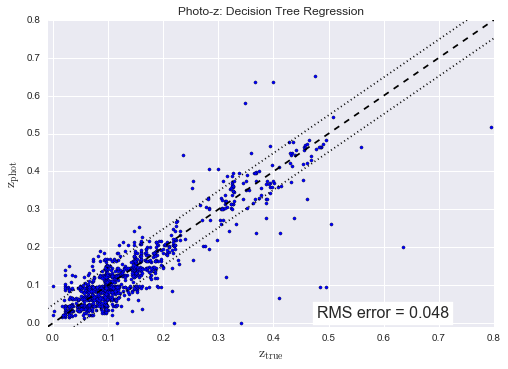

In [67]:
ax = plt.axes()
axis_lim = np.array([-0.01, 0.8])
plt.scatter(ztest, zpred, s=10)# , c='k', lw=0, s=4)
plt.plot(axis_lim, axis_lim, '--k')
plt.plot(axis_lim, axis_lim + rms, ':k')
plt.plot(axis_lim, axis_lim - rms, ':k')
plt.xlim(axis_lim)
plt.ylim(axis_lim)

plt.text(0.9, 0.02, "RMS error = %.2g" % rms,
        ha='right', va='bottom', transform=ax.transAxes,
        bbox=dict(ec='w', fc='w'), fontsize=16)

plt.title('Photo-z: Decision Tree Regression')
plt.xlabel(r'$\mathrm{z_{true}}$', fontsize=14)
plt.ylabel(r'$\mathrm{z_{phot}}$', fontsize=14)

In [68]:
from sklearn.ensemble import RandomForestRegressor

In [69]:
zpred = RandomForestRegressor(100).fit(Xtrain, ztrain).predict(Xtest)

In [70]:
rms = np.sqrt(np.mean((ztest - zpred) ** 2))
print rms
print len(ztest)
print np.sum(abs(ztest - zpred) > 1)

0.0378769839523
1250
0


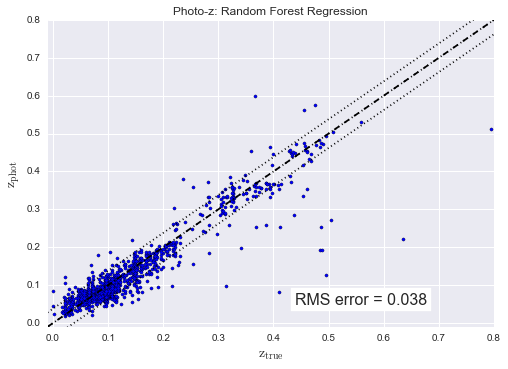

In [71]:
plt.scatter(ztest, zpred, s=10)

axis_lim = np.array([-0.01, 0.8])
plt.plot(axis_lim, axis_lim, '--k')
plt.plot(axis_lim, axis_lim + rms, ':k')
plt.plot(axis_lim, axis_lim - rms, ':k')
plt.xlim(axis_lim)
plt.ylim(axis_lim)

plt.plot([-0.1, 0.8], [-0.1, 0.8], ':k')
plt.text(0.7, 0.02, "RMS error = %.2g" % rms,
        ha='right', va='bottom', transform=ax.transAxes,
        bbox=dict(ec='w', fc='w'), fontsize=16)

plt.title('Photo-z: Random Forest Regression')
plt.xlabel(r'$\mathrm{z_{true}}$', fontsize=14)
plt.ylabel(r'$\mathrm{z_{phot}}$', fontsize=14)

### An ensemble of less perfect estimators can give a more precise result than individual estimators themselves